In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import time
import copy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

[Normalization values](https://github.com/kuangliu/pytorch-cifar/issues/19):

In [4]:
cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

In [5]:
# Data augmentation and normalization for training
# Just normalization for test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=30),
        transforms.ColorJitter(hue=0.25, contrast=5, saturation=5),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
}

In [6]:
import sys
if sys.platform == 'win32':
    data_dir = '_data\cifar10'
else:
    data_dir = os.path.join(os.environ['HOME'], 'hse/nis/cifar10')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# pictures are small: use big batch_size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device: cuda:0


In [7]:
def imshow(inp, title=None, plotter=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array(cifar10_mean), np.array(cifar10_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if not plotter:
        plotter = plt
        plt.figure(figsize=(2,2))
        if title is not None:
            plt.title(title)
    plotter.imshow(inp)
    if not plotter:
        plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [8]:
# inputs[0].shape

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    avg_acc = 0.0

    train_out = {
        'train': {'loss': [], 'acc': []},
        'test': {'loss': [], 'acc': []}
    }

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            train_out[phase]['loss'].append(epoch_loss)
            train_out[phase]['acc'].append(float(epoch_acc.to('cpu').numpy()))

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test':
                avg_acc += epoch_acc
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose:
            print()

    time_elapsed = time.time() - since
    if verbose:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best test Acc: {:4f}'.format(best_acc))
    avg_acc /= num_epochs

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, avg_acc, train_out

In [10]:
def visualize_model(model, num_images=6, show_mistakes=False):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                real_label, predicted_label = \
                    class_names[labels.to('cpu')[j]], class_names[preds[j]]
                if (show_mistakes and real_label == predicted_label) or \
                    (not show_mistakes and real_label != predicted_label):
                    continue
                images_so_far += 1
                title = 'real: {real}\npred: {pred}'.format(
                    real=real_label, pred=predicted_label)
                imshow(inputs.cpu().data[j], title=title)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Training multiple models

### Model specific preprocessing

In [11]:
def lock_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

def default_preprocessing(model, pretrained):
    if pretrained:
        lock_parameters(model)
    in_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_ftrs, len(class_names))

def vgg_preprocessing(model, pretrained):
    if pretrained:
        lock_parameters(model)
    in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_ftrs, len(class_names))

def densenet_preprocessing(model, pretrained):
    if pretrained:
        lock_parameters(model)
    in_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(in_ftrs, len(class_names))
    
def squeezenet_preprocessing(model, pretrained):
    if pretrained:
        lock_parameters(model)
    in_ftrs = model.classifier[1].in_channels
    final_conv = nn.Conv2d(in_ftrs, len(class_names), kernel_size=1)
    model.num_classes = len(class_names)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        final_conv,
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

def preprocess(model, is_vgg=False, is_densenet=False, is_squeezenet=False, pretrained=True):
    if is_vgg:
        vgg_preprocessing(model, pretrained)
    elif is_densenet:
        densenet_preprocessing(model, pretrained)
    elif is_squeezenet:
        squeezenet_preprocessing(model, pretrained)
    else:
        default_preprocessing(model, pretrained)

In [12]:
def multimodel_train(model_data, epochs=25, learning_rate=0.001, m=0.9, pretrained=True,
    do_preprocessing=True):
    """Train multiple models given data in specific format"""
    stats = {}
    for data in models_data:
        criterion = nn.CrossEntropyLoss()
        model = data['model']
        is_vgg = data['is_vgg']
        is_densenet = data['is_densenet']
        is_squeezenet = data['is_squeezenet']
        if do_preprocessing:
            preprocess(model, is_vgg, is_densenet, is_squeezenet, pretrained)
        optimizer_params = dict(lr=learning_rate, momentum=m, nesterov=True)
        parameters = None
        if pretrained:
            if is_vgg:
                parameters = model.classifier[6].parameters
            elif is_densenet:
                parameters = model.classifier.parameters
            elif is_squeezenet:
                parameters = model.classifier.parameters
            else:
                parameters = model.fc.parameters
        else:
            parameters = model.parameters
        optimizer = optim.SGD(parameters(), **optimizer_params)
#         optimizer = optim.Adam(parameters(), lr=learning_rate)
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print('Started training: {}'.format(data['model_name']))
        start = time.time()
        trained_model, best_acc, avg_acc, model_stats = train_model(
            model, criterion, optimizer, exp_lr_scheduler, epochs, verbose=True)
        elapsed = time.time() - start
        print('Trained model: {} | Best Acc: {:.4f} | Avg. Acc: {:.4f}'.format(
            data['model_name'], best_acc, avg_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(elapsed // 60, elapsed % 60))
#         torch.save(trained_model.state_dict(), 'local_{}_{:.4f}.pth'.format(
#             data['model_name'], best_acc))
        stats[data['model_name']] = model_stats
    return stats

In [13]:
# custom models:
from resnet import resnet18, resnet152

In [14]:
models_to_train = {
#     'vgg16_bn': models.vgg16_bn(pretrained=True),    # best test acc: 0.6932
#     'resnet18': models.resnet18(pretrained=True),    # best test acc: 0.6872
#     'resnet50': models.resnet50(pretrained=True),    # best test acc: 0.7210
#     'vgg19_bn': models.vgg19_bn(pretrained=True),    # best test acc: 0.6915
#     'resnet101': models.resnet101(pretrained=True),  # best test acc: 0.7313
    'resnet18': resnet18(),
    'resnet152': resnet152(),
}

In [15]:
models_data = []
for name, model in models_to_train.items():
    models_data.append({
        'model': model,
        'model_name': name,
        'is_vgg': 'vgg' in name,
        'is_densenet': 'densenet' in name,
        'is_squeezenet': 'squeeze' in name
    })

In [16]:
num_epochs = 150

In [17]:
stats = multimodel_train(models_data, epochs=num_epochs, learning_rate=0.1,
    pretrained=False, do_preprocessing=False)

Started training: resnet18
Epoch 0/149
----------
train Loss: 2.2462 Acc: 0.2013
test Loss: 1.7943 Acc: 0.3176

Epoch 1/149
----------
train Loss: 1.7518 Acc: 0.3556
test Loss: 1.5659 Acc: 0.4250

Epoch 2/149
----------
train Loss: 1.5838 Acc: 0.4321
test Loss: 1.4364 Acc: 0.4802

Epoch 3/149
----------
train Loss: 1.4775 Acc: 0.4719
test Loss: 1.3237 Acc: 0.5321

Epoch 4/149
----------
train Loss: 1.3719 Acc: 0.5102
test Loss: 1.1647 Acc: 0.5848

Epoch 5/149
----------
train Loss: 1.2982 Acc: 0.5408
test Loss: 1.2000 Acc: 0.5708

Epoch 6/149
----------
train Loss: 1.2355 Acc: 0.5654
test Loss: 1.0962 Acc: 0.6119

Epoch 7/149
----------
train Loss: 1.1858 Acc: 0.5818
test Loss: 0.9837 Acc: 0.6530

Epoch 8/149
----------
train Loss: 1.1410 Acc: 0.6007
test Loss: 0.9589 Acc: 0.6629

Epoch 9/149
----------
train Loss: 1.1032 Acc: 0.6119
test Loss: 0.9470 Acc: 0.6687

Epoch 10/149
----------
train Loss: 1.0721 Acc: 0.6253
test Loss: 0.9291 Acc: 0.6774

Epoch 11/149
----------
train Loss: 1

Epoch 95/149
----------
train Loss: 0.4915 Acc: 0.8265
test Loss: 0.6235 Acc: 0.7989

Epoch 96/149
----------
train Loss: 0.4878 Acc: 0.8306
test Loss: 0.6226 Acc: 0.7998

Epoch 97/149
----------
train Loss: 0.4881 Acc: 0.8289
test Loss: 0.6257 Acc: 0.7991

Epoch 98/149
----------
train Loss: 0.4870 Acc: 0.8303
test Loss: 0.6256 Acc: 0.7978

Epoch 99/149
----------
train Loss: 0.4923 Acc: 0.8258
test Loss: 0.6208 Acc: 0.7992

Epoch 100/149
----------
train Loss: 0.4933 Acc: 0.8275
test Loss: 0.6242 Acc: 0.7986

Epoch 101/149
----------
train Loss: 0.4951 Acc: 0.8262
test Loss: 0.6260 Acc: 0.7982

Epoch 102/149
----------
train Loss: 0.4931 Acc: 0.8266
test Loss: 0.6213 Acc: 0.7981

Epoch 103/149
----------
train Loss: 0.4910 Acc: 0.8274
test Loss: 0.6235 Acc: 0.7984

Epoch 104/149
----------
train Loss: 0.4909 Acc: 0.8286
test Loss: 0.6283 Acc: 0.7987

Epoch 105/149
----------
train Loss: 0.4891 Acc: 0.8293
test Loss: 0.6274 Acc: 0.7980

Epoch 106/149
----------
train Loss: 0.4905 Acc:

test Loss: 1.1270 Acc: 0.5997

Epoch 38/149
----------
train Loss: 1.2002 Acc: 0.5758
test Loss: 1.1309 Acc: 0.6020

Epoch 39/149
----------
train Loss: 1.1930 Acc: 0.5768
test Loss: 1.1177 Acc: 0.6028

Epoch 40/149
----------
train Loss: 1.1877 Acc: 0.5803
test Loss: 1.1148 Acc: 0.6072

Epoch 41/149
----------
train Loss: 1.1820 Acc: 0.5815
test Loss: 1.1119 Acc: 0.6077

Epoch 42/149
----------
train Loss: 1.1819 Acc: 0.5818
test Loss: 1.1103 Acc: 0.6101

Epoch 43/149
----------
train Loss: 1.1765 Acc: 0.5826
test Loss: 1.1085 Acc: 0.6101

Epoch 44/149
----------
train Loss: 1.1715 Acc: 0.5863
test Loss: 1.1066 Acc: 0.6099

Epoch 45/149
----------
train Loss: 1.1678 Acc: 0.5880
test Loss: 1.1030 Acc: 0.6113

Epoch 46/149
----------
train Loss: 1.1651 Acc: 0.5874
test Loss: 1.1120 Acc: 0.6072

Epoch 47/149
----------
train Loss: 1.1613 Acc: 0.5894
test Loss: 1.0993 Acc: 0.6131

Epoch 48/149
----------
train Loss: 1.1588 Acc: 0.5899
test Loss: 1.0999 Acc: 0.6124

Epoch 49/149
----------

train Loss: 1.0208 Acc: 0.6409
test Loss: 1.0654 Acc: 0.6319

Epoch 133/149
----------
train Loss: 1.0258 Acc: 0.6360
test Loss: 1.0673 Acc: 0.6338

Epoch 134/149
----------
train Loss: 1.0271 Acc: 0.6348
test Loss: 1.0689 Acc: 0.6332

Epoch 135/149
----------
train Loss: 1.0209 Acc: 0.6376
test Loss: 1.0681 Acc: 0.6337

Epoch 136/149
----------
train Loss: 1.0241 Acc: 0.6395
test Loss: 1.0671 Acc: 0.6330

Epoch 137/149
----------
train Loss: 1.0221 Acc: 0.6394
test Loss: 1.0710 Acc: 0.6339

Epoch 138/149
----------
train Loss: 1.0220 Acc: 0.6389
test Loss: 1.0673 Acc: 0.6341

Epoch 139/149
----------
train Loss: 1.0252 Acc: 0.6377
test Loss: 1.0650 Acc: 0.6347

Epoch 140/149
----------
train Loss: 1.0251 Acc: 0.6386
test Loss: 1.0676 Acc: 0.6330

Epoch 141/149
----------
train Loss: 1.0194 Acc: 0.6416
test Loss: 1.0674 Acc: 0.6338

Epoch 142/149
----------
train Loss: 1.0208 Acc: 0.6400
test Loss: 1.0672 Acc: 0.6336

Epoch 143/149
----------
train Loss: 1.0255 Acc: 0.6390
test Loss: 1

In [18]:
losses = {}
accuracies = {}
model_test_accuracies = {}  # used later in visualization
for model_name, model_stats in stats.items():
    for phase, phase_stats in model_stats.items():
        key = '{model} {phase}'.format(model=model_name, phase=phase)
        losses[key] = phase_stats['loss']
        accuracies[key] = phase_stats['acc']
        if phase == 'test':
            model_test_accuracies[model_name] = phase_stats['acc']

## Loss

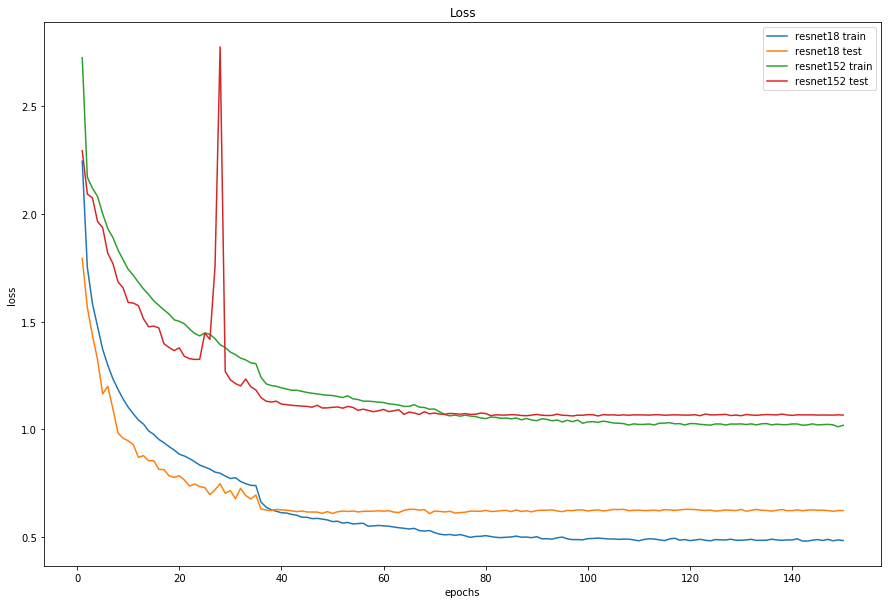

In [19]:
plt.figure(figsize=(15,10))
for name, values in losses.items():
    plt.plot(range(1, num_epochs+1, 1), values, '-', label=name)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.title('Loss')
pass

## Accuracy

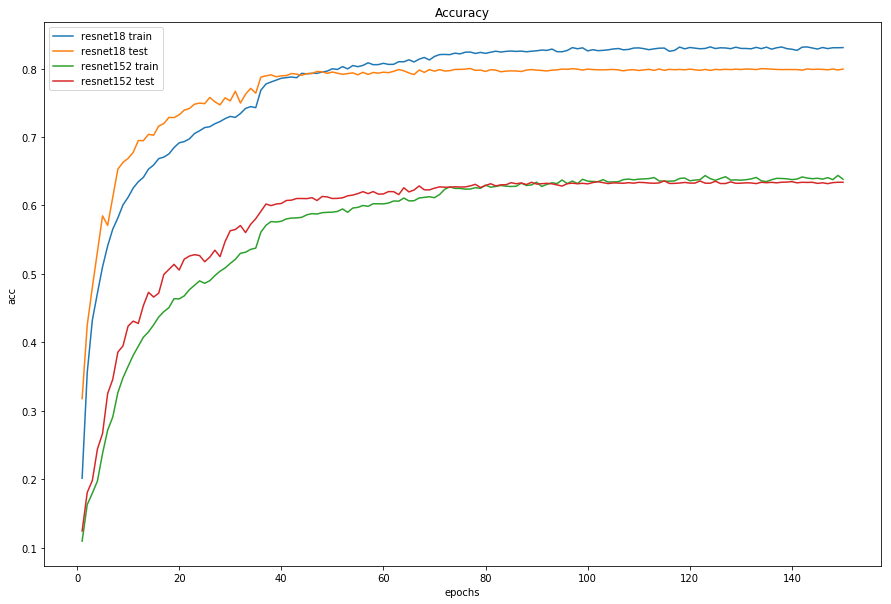

In [20]:
plt.figure(figsize=(15,10))
for name, values in accuracies.items():
    plt.plot(range(1, num_epochs+1, 1), values, '-', label=name)
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='best')
plt.title('Accuracy')
pass

# Visualization

In [21]:
best_model_name = sorted(model_test_accuracies.items(), key=lambda x: x[1][-1], reverse=True)[0][0]
print('Model with best accuracy:', best_model_name)

Model with best accuracy: resnet18


In [22]:
models_to_visualize = {d['model_name']: d['model'] for d in models_data}

In [23]:
best_model = models_to_visualize[best_model_name]

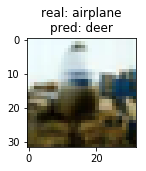

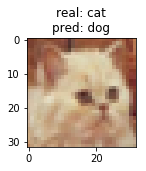

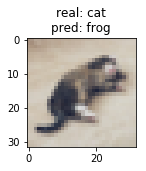

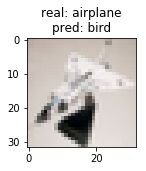

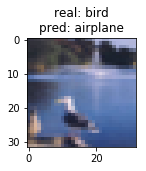

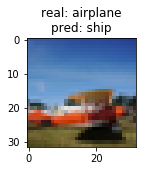

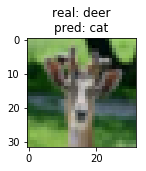

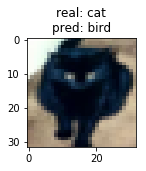

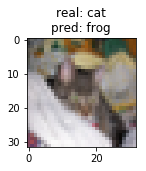

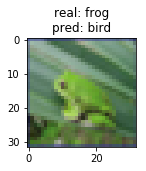

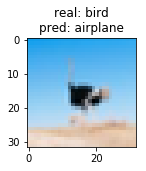

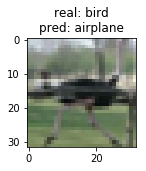

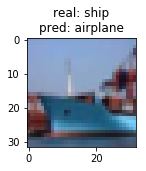

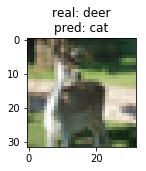

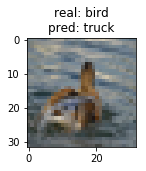

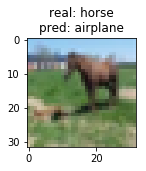

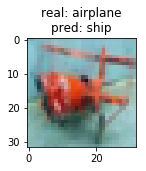

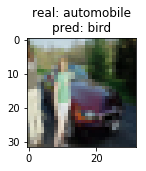

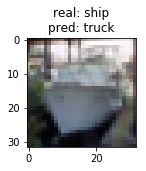

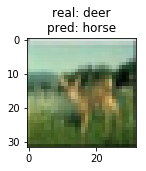

In [24]:
visualize_model(best_model, num_images=20, show_mistakes=True)

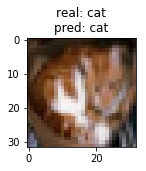

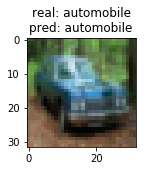

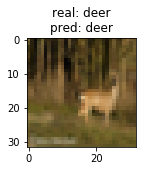

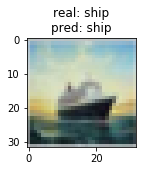

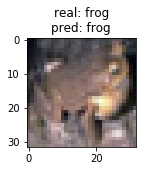

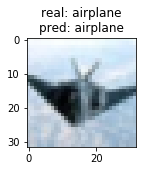

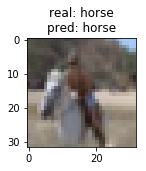

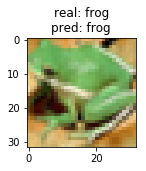

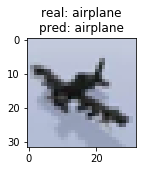

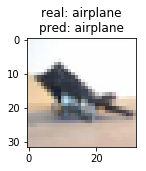

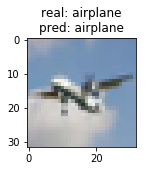

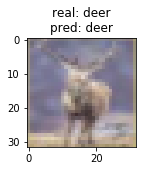

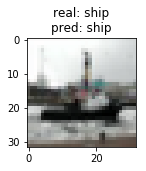

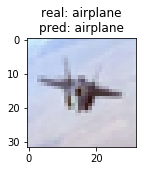

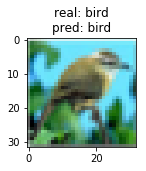

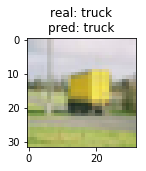

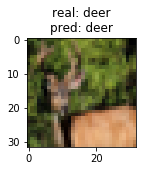

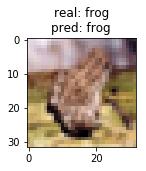

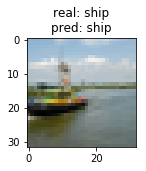

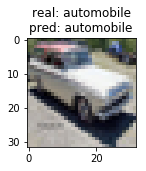

In [25]:
visualize_model(best_model, num_images=20, show_mistakes=False)

# Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
def confusion(model):
    real_labels = []
    pred_labels = []
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                real_labels.append(int(labels.to('cpu')[j]))
                pred_labels.append(int(preds[j]))
                
        model.train(mode=was_training)
    return confusion_matrix(real_labels, pred_labels)

In [27]:
confmat = confusion(best_model)

In [28]:
confmat

array([[850,  13,  25,  14,  15,   5,   4,   8,  42,  24],
       [  8, 894,   7,   4,   2,   3,   3,   3,  15,  61],
       [ 42,   4, 717,  61,  63,  48,  33,  21,   6,   5],
       [ 17,   9,  53, 656,  44, 126,  47,  26,   9,  13],
       [ 11,   6,  37,  55, 753,  47,  26,  51,   7,   7],
       [ 11,   2,  39, 161,  24, 679,  31,  40,   3,  10],
       [  6,   4,  25,  54,  23,  28, 843,   2,   4,  11],
       [  8,   2,  21,  33,  33,  30,   1, 857,   3,  12],
       [ 40,  19,   9,  12,   6,   2,   2,   1, 886,  23],
       [ 24,  51,   9,  10,   2,   6,   4,   7,  21, 866]], dtype=int64)

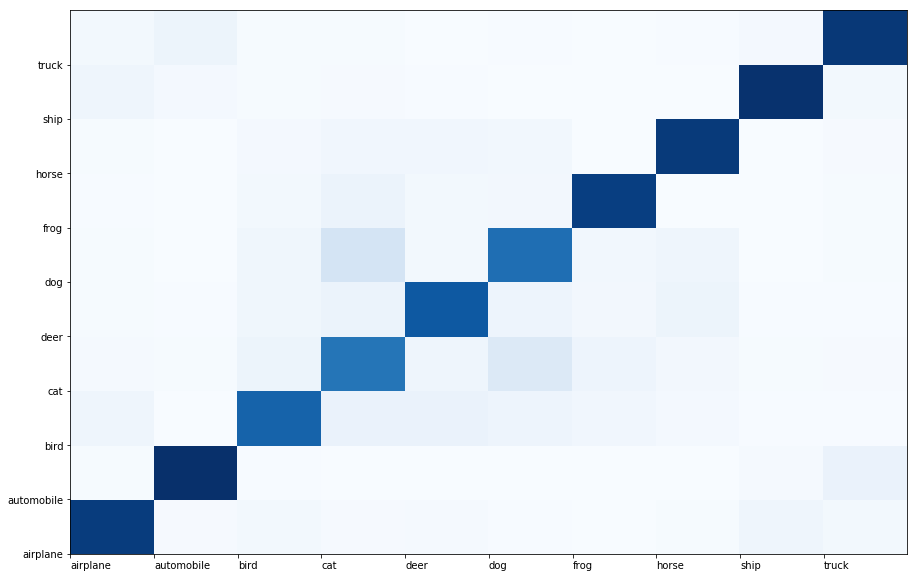

In [29]:
plt.figure(figsize=(15,10))
plt.xticks(ticks=range(len(class_names)), labels=class_names, ha='left')
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.pcolor(confmat, cmap='Blues')
pass